# Regressão Linear Múltipla

O objetivo deste notebook é explorar a regressão múltipla e engenharia de atributos com as funções da API Scikit-learn.

Neste notebook você irá manipular dados de transações imobiliárias de King County para prever preços usando regressão múltipla. Desta forma, você poderá:
* Usar Pandas DataFrames para realizar algumas atividades de engenharia de atributos
* Usar funções do Scikit-learn para computar os coeficientes de regressão (pesos/parâmetros)
* Dados os coeficientes de regressão, os preditores e a saída (preços), criar uma função para computar erro utilizando a técnica de mínimos quadrados (Residual Sum of Squares).
* Visualizar os coeficientes e interpretar seus significados

## Importação das bibliotecas

Importação de bibliotecas necessárias para a execução dos comandos:
* Pandas: para manipulação dos dados
* Numpy: para compatibilizar o uso de dados por algumas funções
* Datetime: para formatar um dos atributos da base de dados
* Sklearn: para uso comparativo de funções de regressão linear

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostRegressor
from numpy import mean
from numpy import std

import warnings
warnings.filterwarnings('ignore')

## <center>**Leitura dos dados**</center>

O dataset contém dados de transações imobiliárias de King County, região aonde está a cidade de Seattle, USA.


### <center>*Dicionário de variáveis 1*</center>

![dicionario](https://miro.medium.com/v2/resize:fit:640/format:webp/1*aBClHGo8tIhVFrnpKN3-dw.jpeg)

### <center>*Dicionário de variáveis 2*</center>

id — unique identifier for a house

date — date of the home sale

bedrooms — number of bedrooms

bathrooms — number of bathrooms

sqft_living — square footage of the house’s interior living space

sqft_lot — square footage of the land space

floors — number of floors

waterfront — does the house have a view to the waterfront?

view — an index from 0 to 4 of how good the view of the property was

condition — an index from 1 to 5 on the condition of the house

grade — an index from 1 to 13, where 1–3 falls short of building construction and design, 7 has an average level of construction and design, and 11–13 have a high quality level of construction and design

sqft_above — square feet above ground

sqft_basement — square feet below ground

yr_built— the year the house was initially built

yr_renovated — the year of the house’s last renovation (0 if never renovated)

zipcode — zip

lat — latitude coordinate

long — longitude coordinate

sqft_living15 — average size of interior housing living space for the closest 15 houses, in square feet

sqft_lot15 — average size of land lot for the closest 15 houses, in square feet

In [4]:
df = pd.read_csv("kc_house_data.csv")
sales = df.copy()

## <center>**Análise Exploratória dos Dados <br> Exploratory Data Analysis (EDA) e Pré-processamento**</center>

Antes de criarmos o modelo de regressão, vamos primeiro explorar os dados:
* Por meio do uso de algumas funções nativas do Pandas (**.info()** e **.describe()**) é possível extrair uma visão geral dos atributos do dataset;
    * A função *info()* retorna informações específicas sobre os tipos de dados de cada um dos atributos, além de informações sobre uso de memória pela estrutura do mesmo;
    * A função *describe()* retorna informações estatísticas em geral referentes aos dados de cada atributo.

#### Eliminação manual de atributos que direta ou indiretamente não contribuem para o modelo

Remoção dos atributos *'id' e 'date'*

In [5]:
sales.drop(
        ['id'],
        axis=1,
        inplace=True
        )
sales.drop(
        ['date'],
        axis=1,
        inplace=True
        )

In [6]:
sales.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

In [8]:
sales.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Verificação de quantos objetos contém valor igual a ZERO para cada um dos parâmetros
Esta análise indica, de imediato, uma "luz vermelha" que devemos considerar quanto aos parâmetros **waterfront**, **view**, **yr_renovated** e **sqft_basement**. 
* Quase todos os parâmetros contém aproximadamente **90%** ou mais de seus dados com valor igual a zero.

In [9]:
(sales[sales[sales.columns] == 0]).count()

price                0
bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21450
view             19489
condition            0
grade                0
sqft_above           0
sqft_basement    13126
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

### Verificação de quantos valores únicos cada atributo possui
Esta verificação foi realizada para se ter uma visão geral dos intervalos de valores que cada atributo apresenta.

In [10]:
sales.nunique()

price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

O comando abaixo identifica os atributos com menor quantidade de valores únicos (<= 20):

In [11]:
sales.nunique()<=20

price            False
bedrooms          True
bathrooms        False
sqft_living      False
sqft_lot         False
floors            True
waterfront        True
view              True
condition         True
grade             True
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [12]:
colunas = sales.columns.to_list()
colunas

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [13]:
sales.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### Organizando as variáveis

Separando as variáveis:

* Quantitativas:

'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15'

* Qualitativas:

'waterfront', 'view', 'condition', 'grade'

* Localização:

'zipcode', 'lat', 'long'

In [14]:
colunas_quant = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

colunas_quali = ['waterfront', 'view', 'condition', 'grade']

colunas_loc = ['zipcode', 'lat', 'long']

key_colunas = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'waterfront', 'view', 'condition', 'grade', 'zipcode', 'lat', 'long']

In [15]:
titulos = {
    'price':'Preço',
    'bedrooms':'Quartos',
    'bathrooms': 'Banheiros',
    'sqft_living':'Área Construída',
    'sqft_lot': 'Área do Lote',
    'floors':'Andares',
    'waterfront':'Beira-água',
    'view':'Vista',
    'condition':'Condição',
    'grade':'Nota',
    'sqft_above':'Área Útil',
    'sqft_basement':'Área do Porão',
    'yr_built':'Ano de Construção',
    'yr_renovated':'Ano da Reforma',
    'zipcode':'Código Postal',
    'lat':'Latitude',
    'long':'Longitude',
    'sqft_living15':'Área Construída dos 15 vizinhos mais próximos',
    'sqft_lot15': 'Área do Lote dos 15 vizinhos mais próximos',
    'coordinates':'Coordenadas',
    'yr_modified':'Anos desde a última modificação',
    'basement':'Porão'
    }

### Gráficos das variáveis

Text(0.5, 0.92, 'Histograma das variáveis')

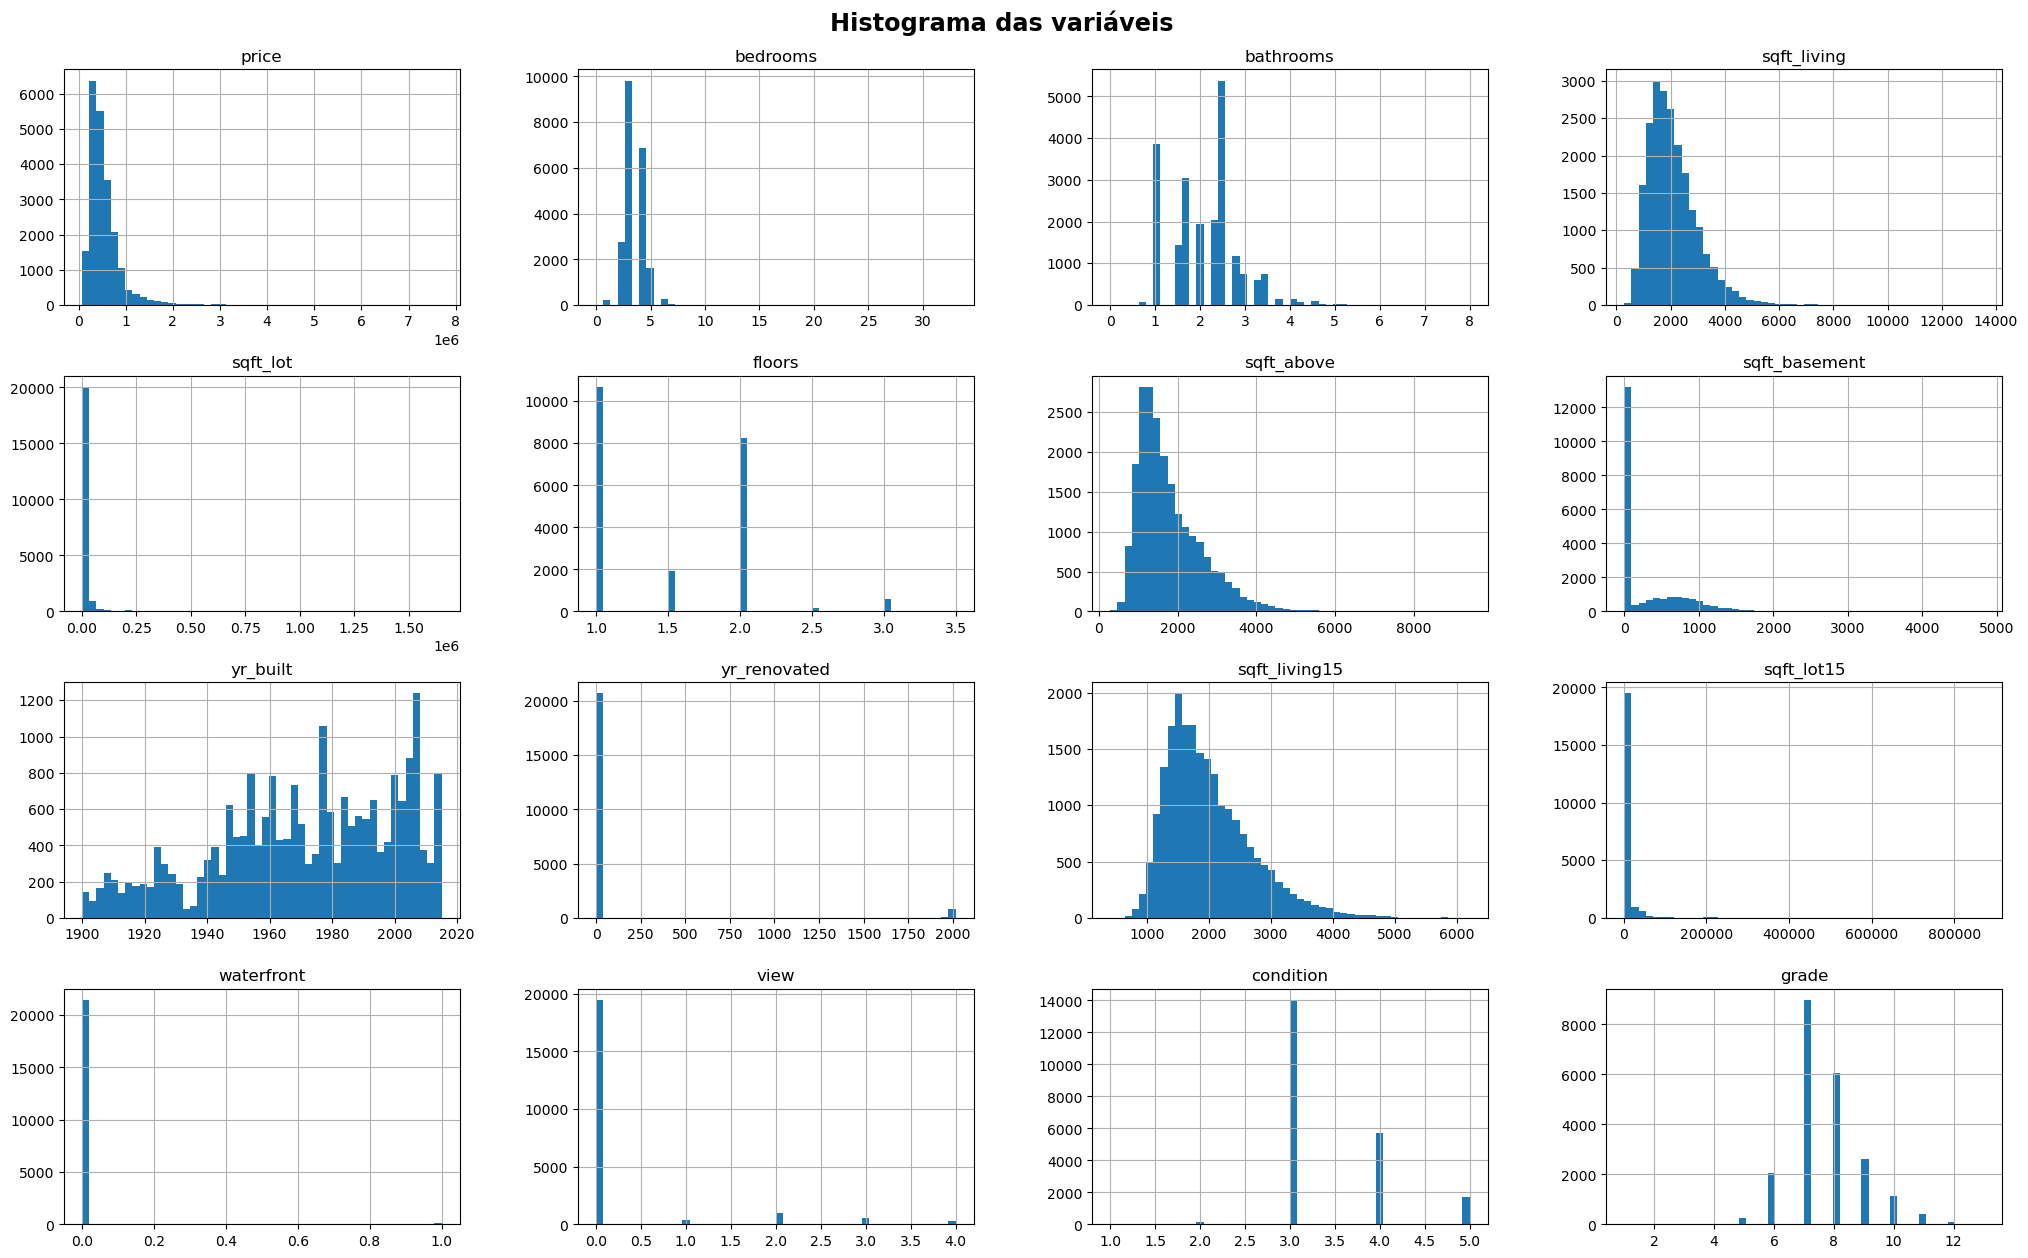

In [16]:
sales[colunas_quant+colunas_quali].hist(bins=50, figsize=(25,15))
plt.suptitle(
    'Histograma das variáveis',
    size='xx-large',
    weight='bold',
    y = .92
    )

Text(0.5, 0.92, 'Distribuição das variáveis')

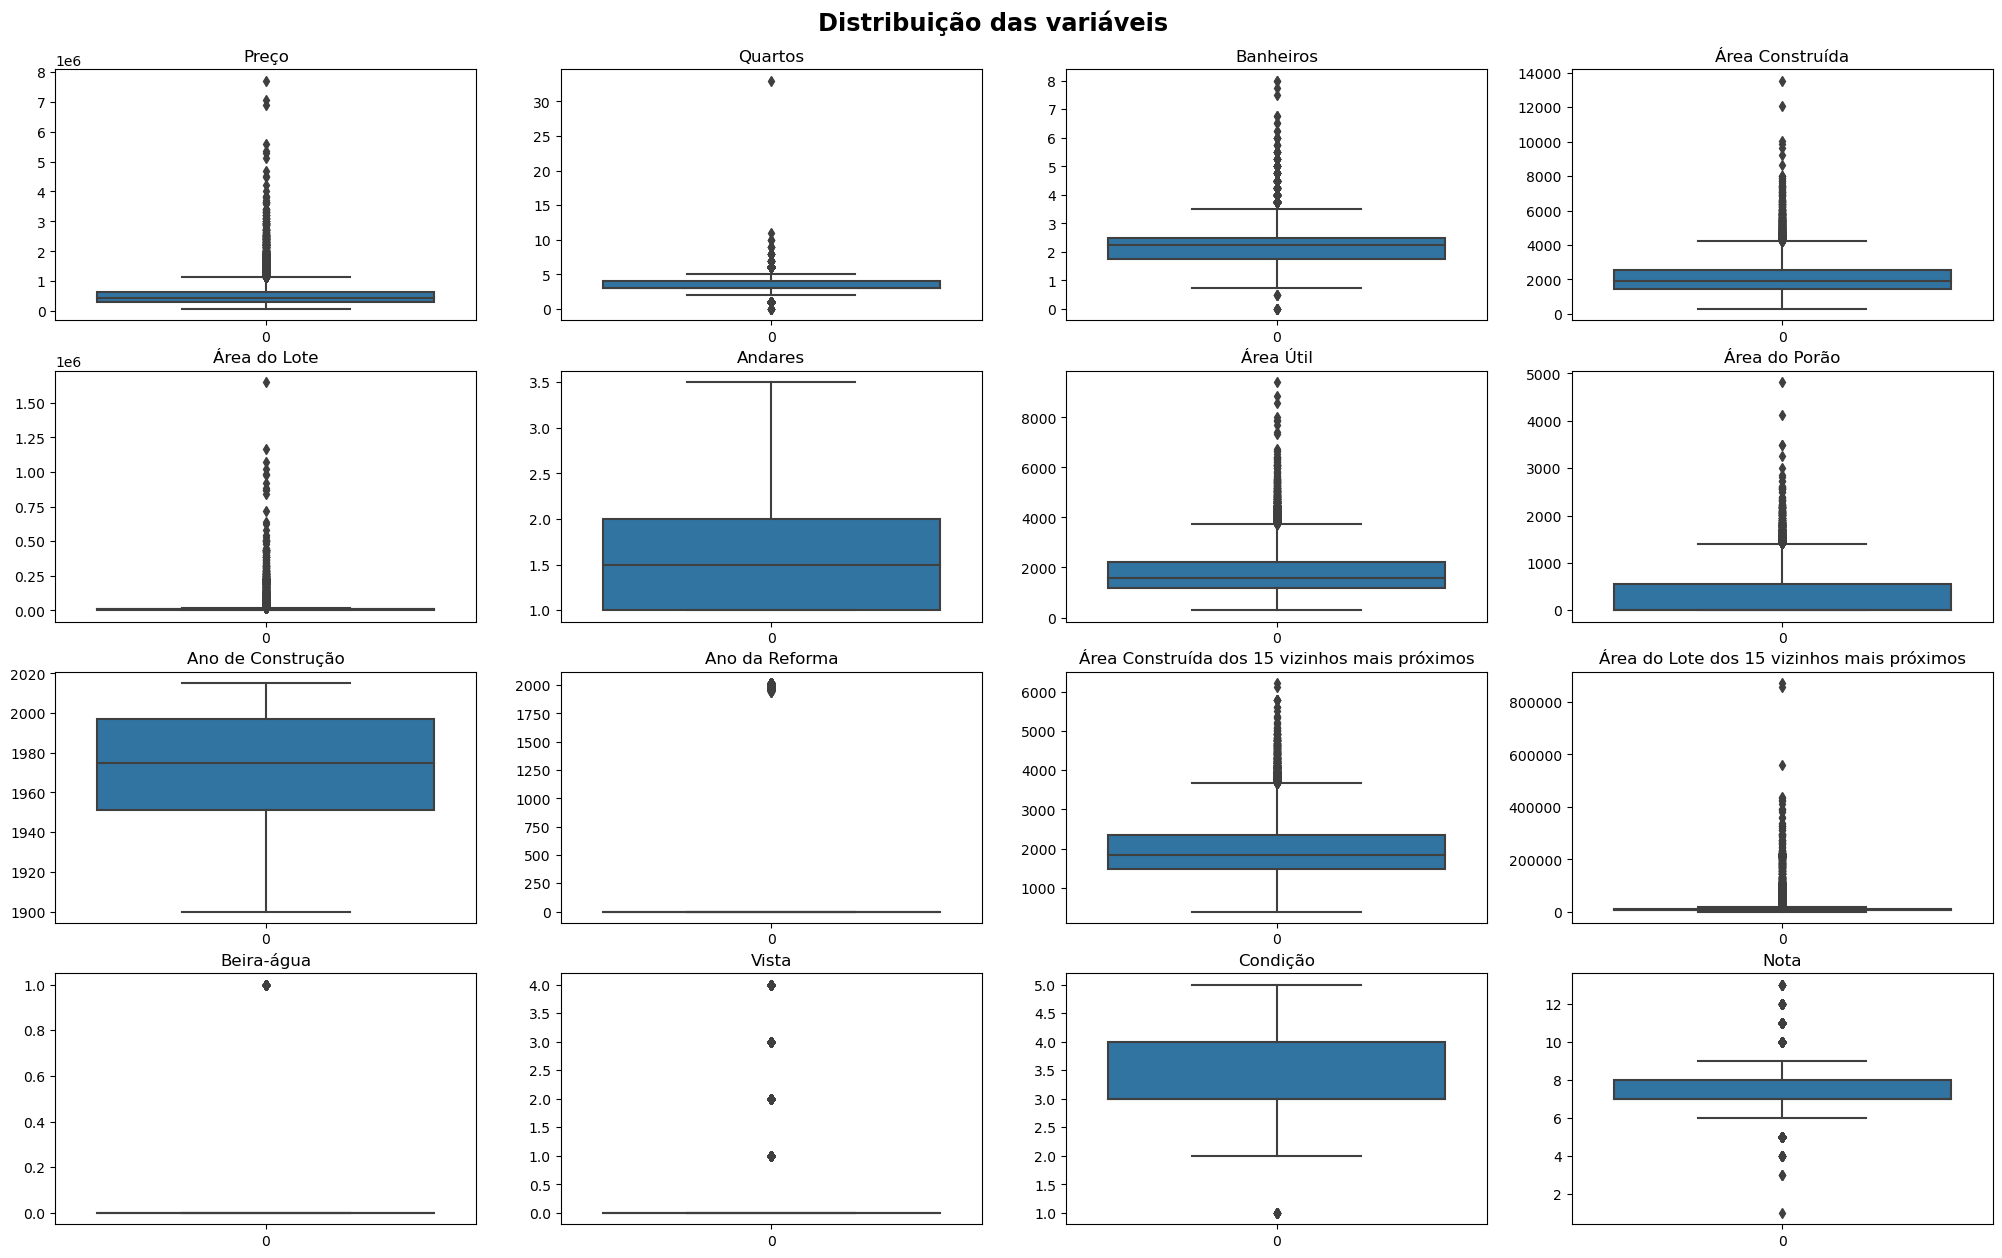

In [17]:
fig, ax = plt.subplots(4, 4, figsize=(25,15))
i=0
for col in colunas_quant+colunas_quali:
    sns.boxplot(
        sales[col],
        ax=ax[int(i/4),i%4]
        ).set_title(titulos[col])
    i+=1

plt.suptitle(
    'Distribuição das variáveis',
    size='xx-large',
    weight='bold',
    y=0.92
    )

Text(0.5, 0.92, 'Relação das variáveis com o preço')

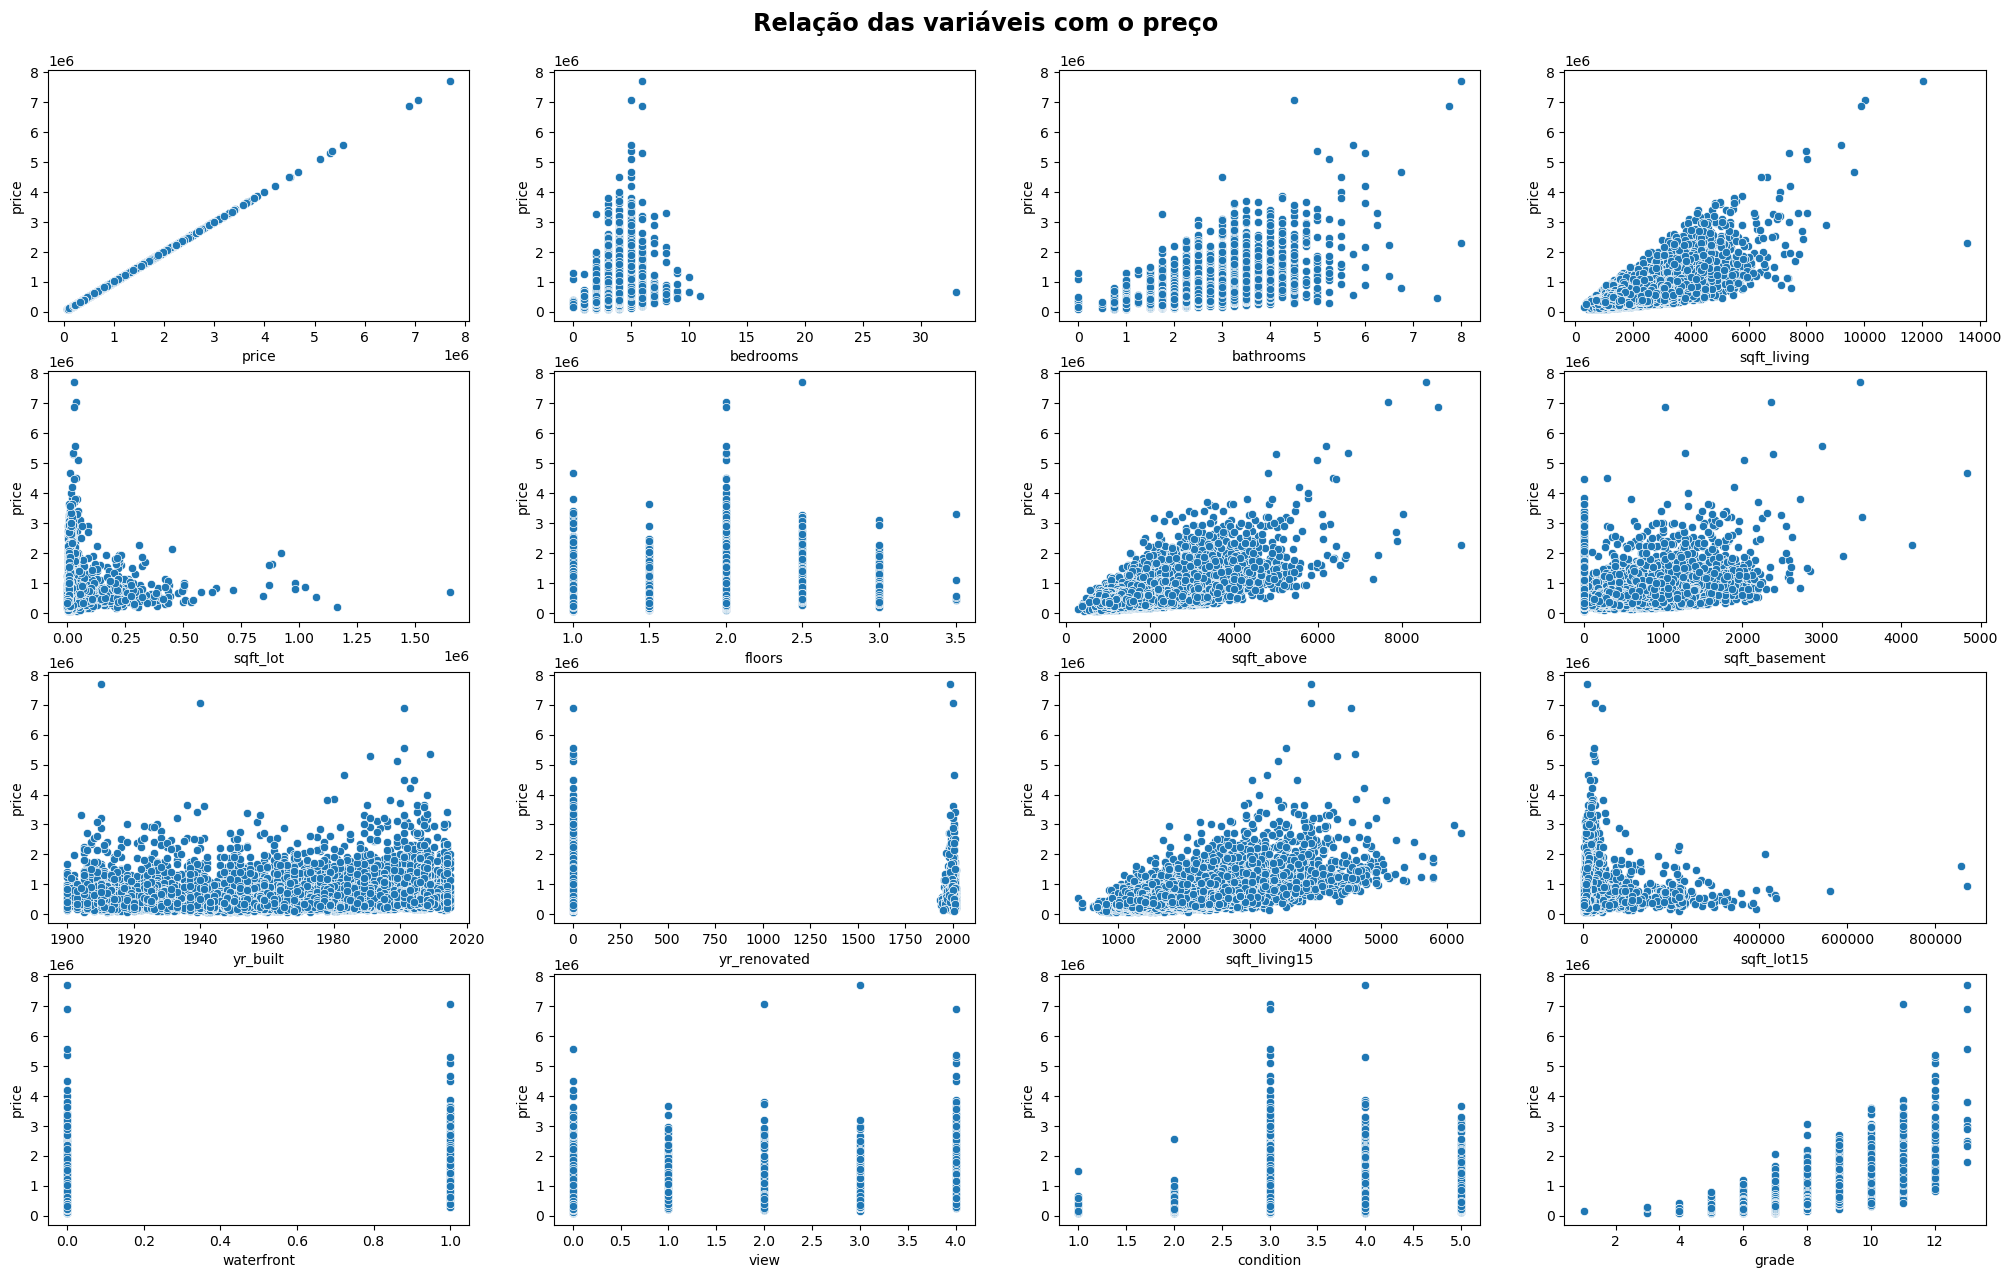

In [18]:
fig, ax = plt.subplots(4, 4, figsize=(25,15))
i=0
for col in colunas_quant+colunas_quali:
    sns.scatterplot(
        sales,
        x=sales[col],
        y=sales['price'],
        ax=ax[int(i/4),i%4]
        )
    i+=1

plt.suptitle(
    'Relação das variáveis com o preço',
    size='xx-large',
    weight='bold',
    y=0.92
    )

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='bedrooms', ylabel='price'>,
        <Axes: xlabel='bathrooms', ylabel='price'>,
        <Axes: xlabel='sqft_living', ylabel='price'>,
        <Axes: xlabel='sqft_lot', ylabel='price'>,
        <Axes: xlabel='floors', ylabel='price'>,
        <Axes: xlabel='sqft_above', ylabel='price'>,
        <Axes: xlabel='sqft_basement', ylabel='price'>,
        <Axes: xlabel='yr_built', ylabel='price'>,
        <Axes: xlabel='yr_renovated', ylabel='price'>,
        <Axes: xlabel='sqft_living15', ylabel='price'>,
        <Axes: xlabel='sqft_lot15', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='bedrooms'>,
        <Axes: xlabel='bedrooms', ylabel='bedrooms'>,
        <Axes: xlabel='bathrooms', ylabel='bedrooms'>,
        <Axes: xlabel='sqft_living', ylabel='bedrooms'>,
        <Axes: xlabel='sqft_lot', ylabel='bedrooms'>,
        <Axes: xlabel='floors', ylabel='bedrooms'>,
        <Axes: xlabel='sqft_above', ylabel='bed

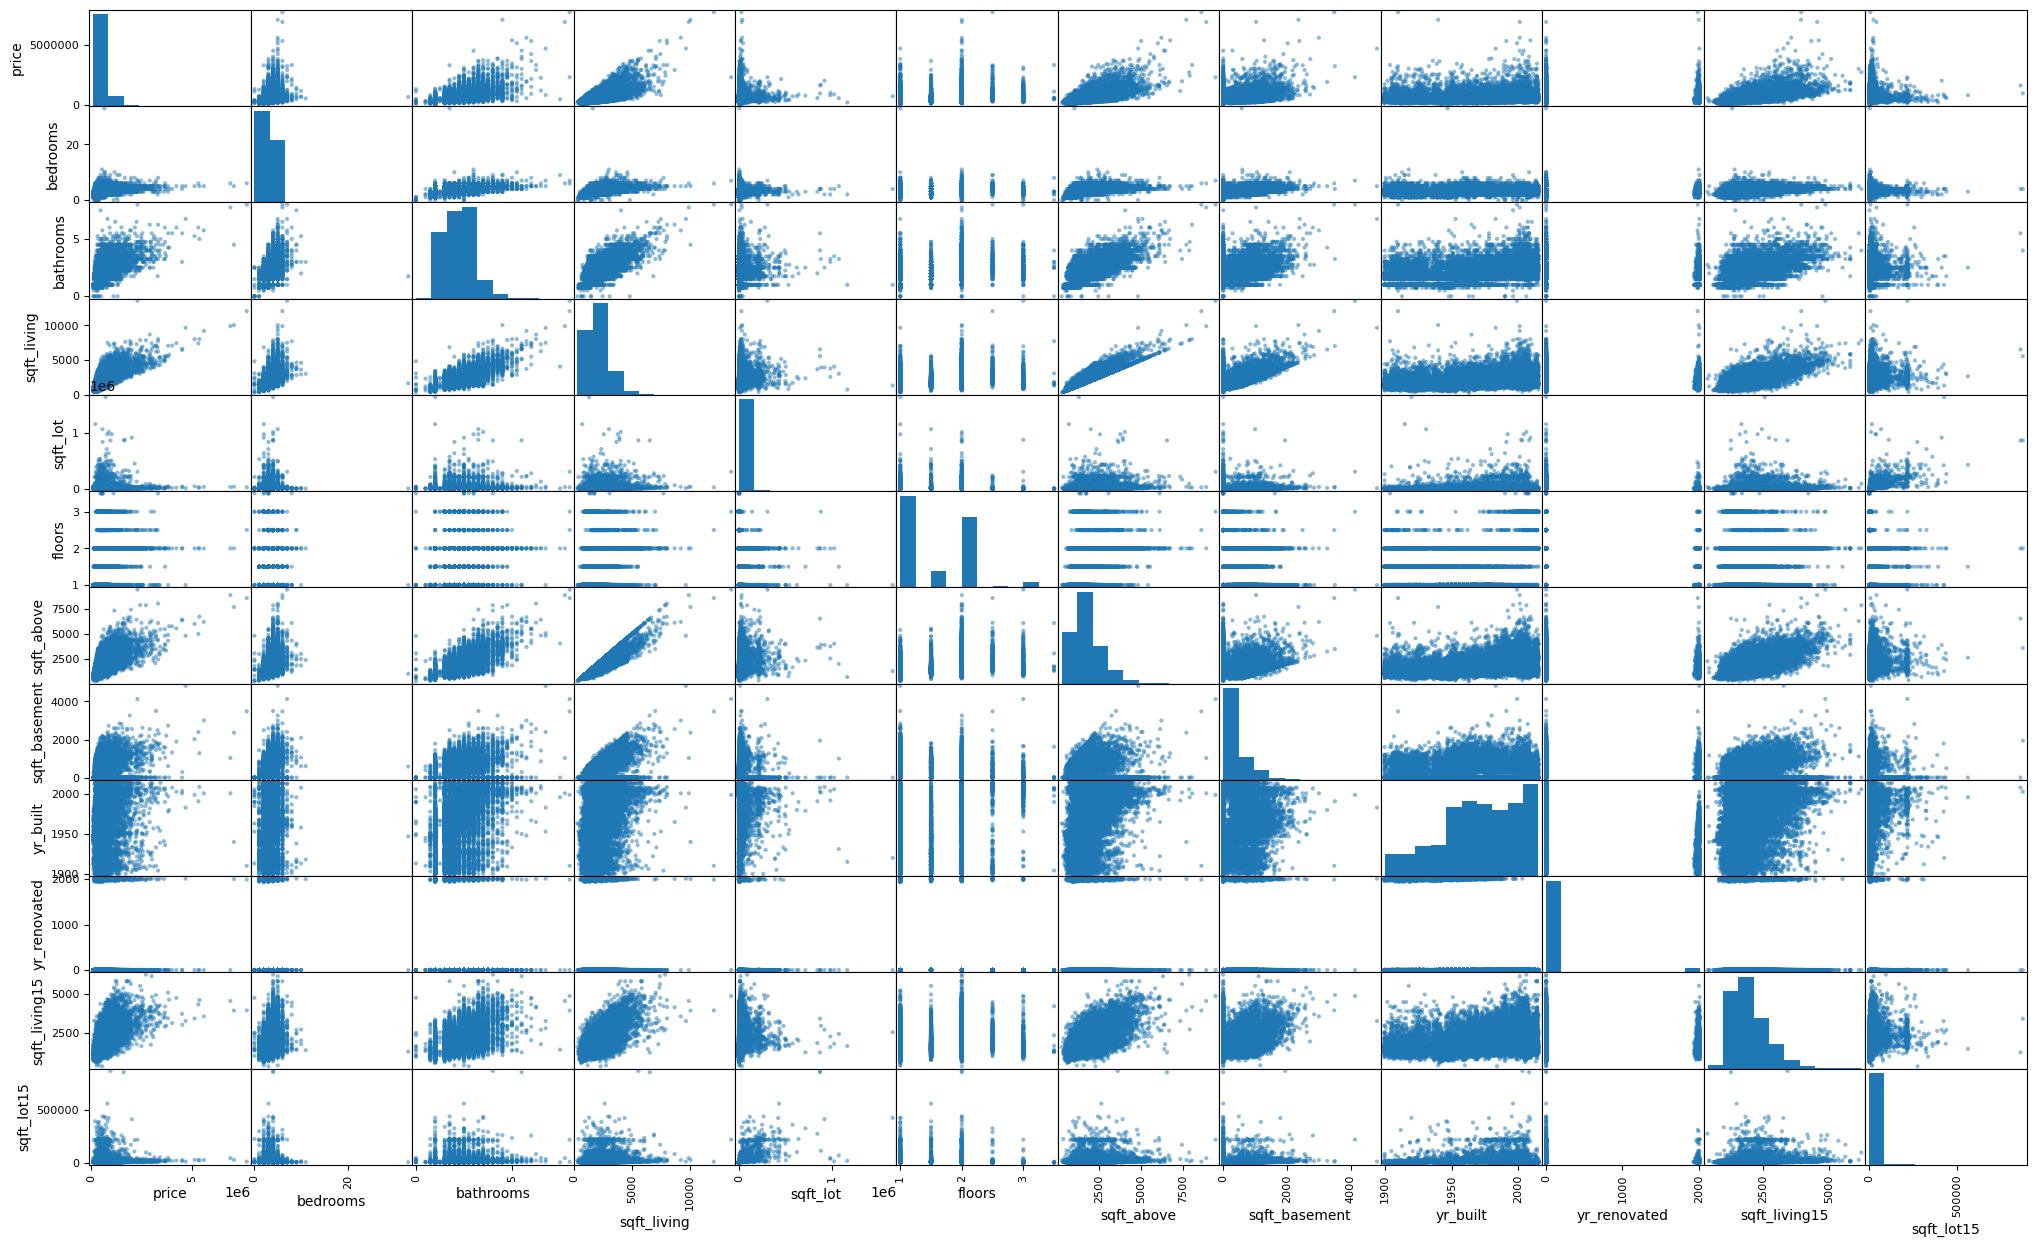

In [19]:
pd.plotting.scatter_matrix(
    sales[colunas_quant],
    figsize=(25, 15)
    )

Text(0.5, 0.92, 'Mapa de calor com a correlação entre as variáveis')

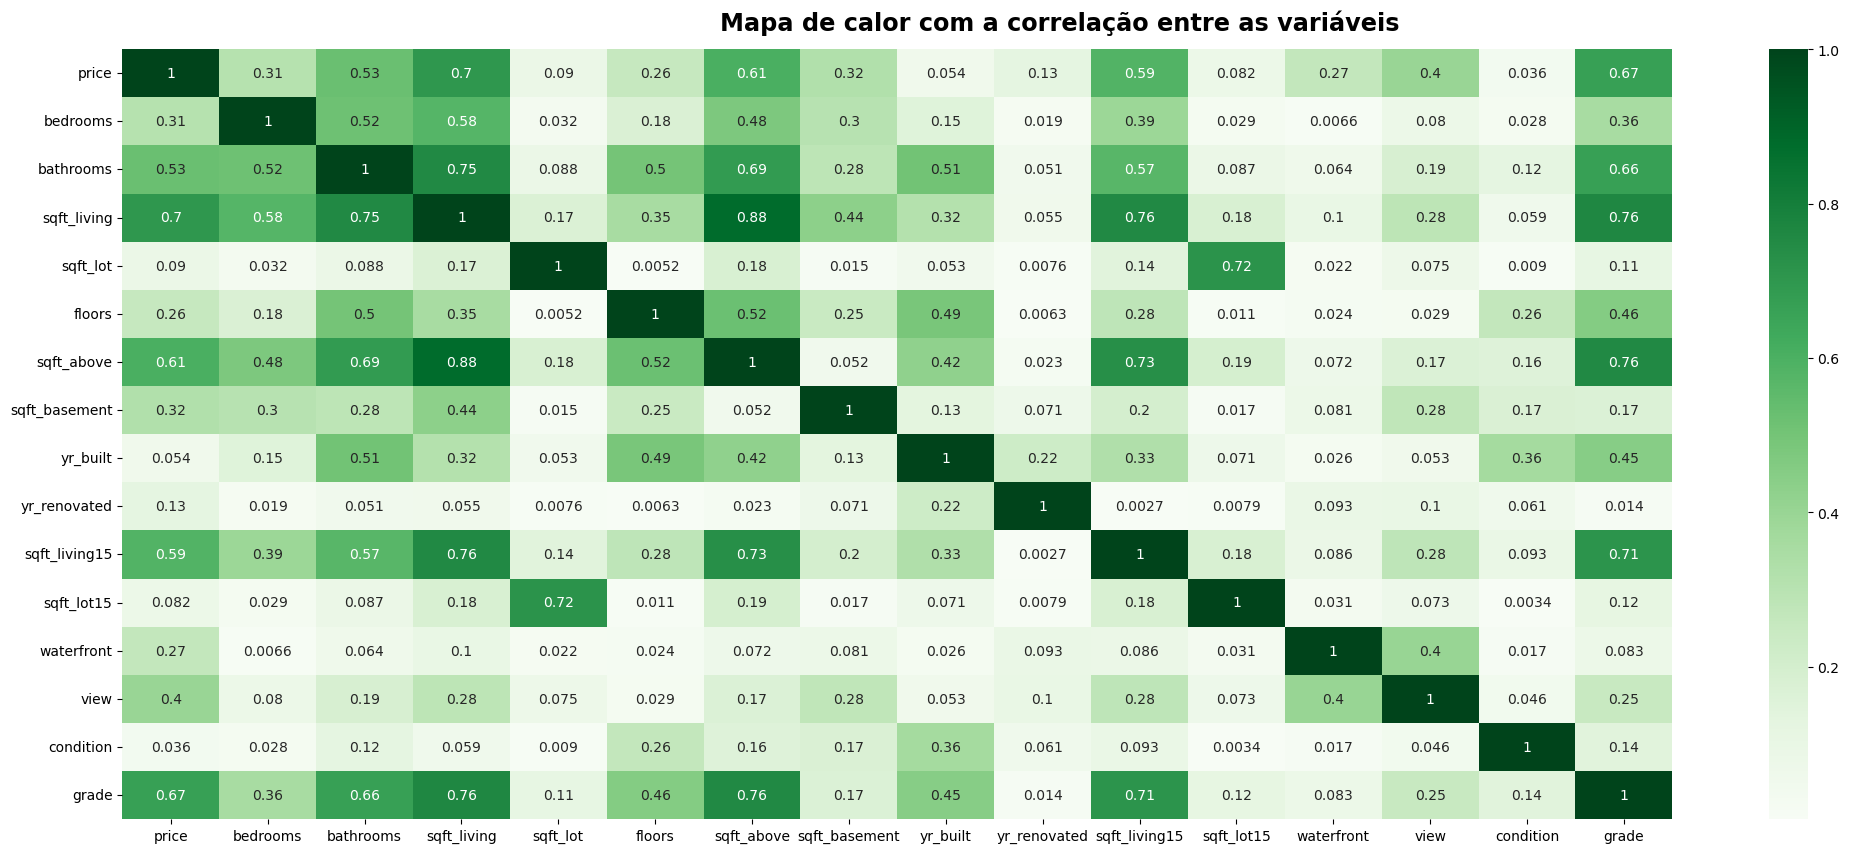

In [20]:
plt.figure(figsize=(25,10))
sns.heatmap(
    np.abs(sales[colunas_quant+colunas_quali].corr()),
    annot=True,
    cmap='Greens'
    )
plt.suptitle(
    'Mapa de calor com a correlação entre as variáveis',
    size='xx-large',
    weight='bold',
    y=0.92
    )


In [21]:
abs(sales[colunas_quant+colunas_quali].corr())>.6

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,waterfront,view,condition,grade
price,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,True
sqft_living,True,False,True,True,False,False,True,False,False,False,True,False,False,False,False,True
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
sqft_above,True,False,True,True,False,False,True,False,False,False,True,False,False,False,False,True
sqft_basement,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
yr_built,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
yr_renovated,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


Text(0.5, 0.92, 'Relação das variáveis com o preço e linha de regressão')

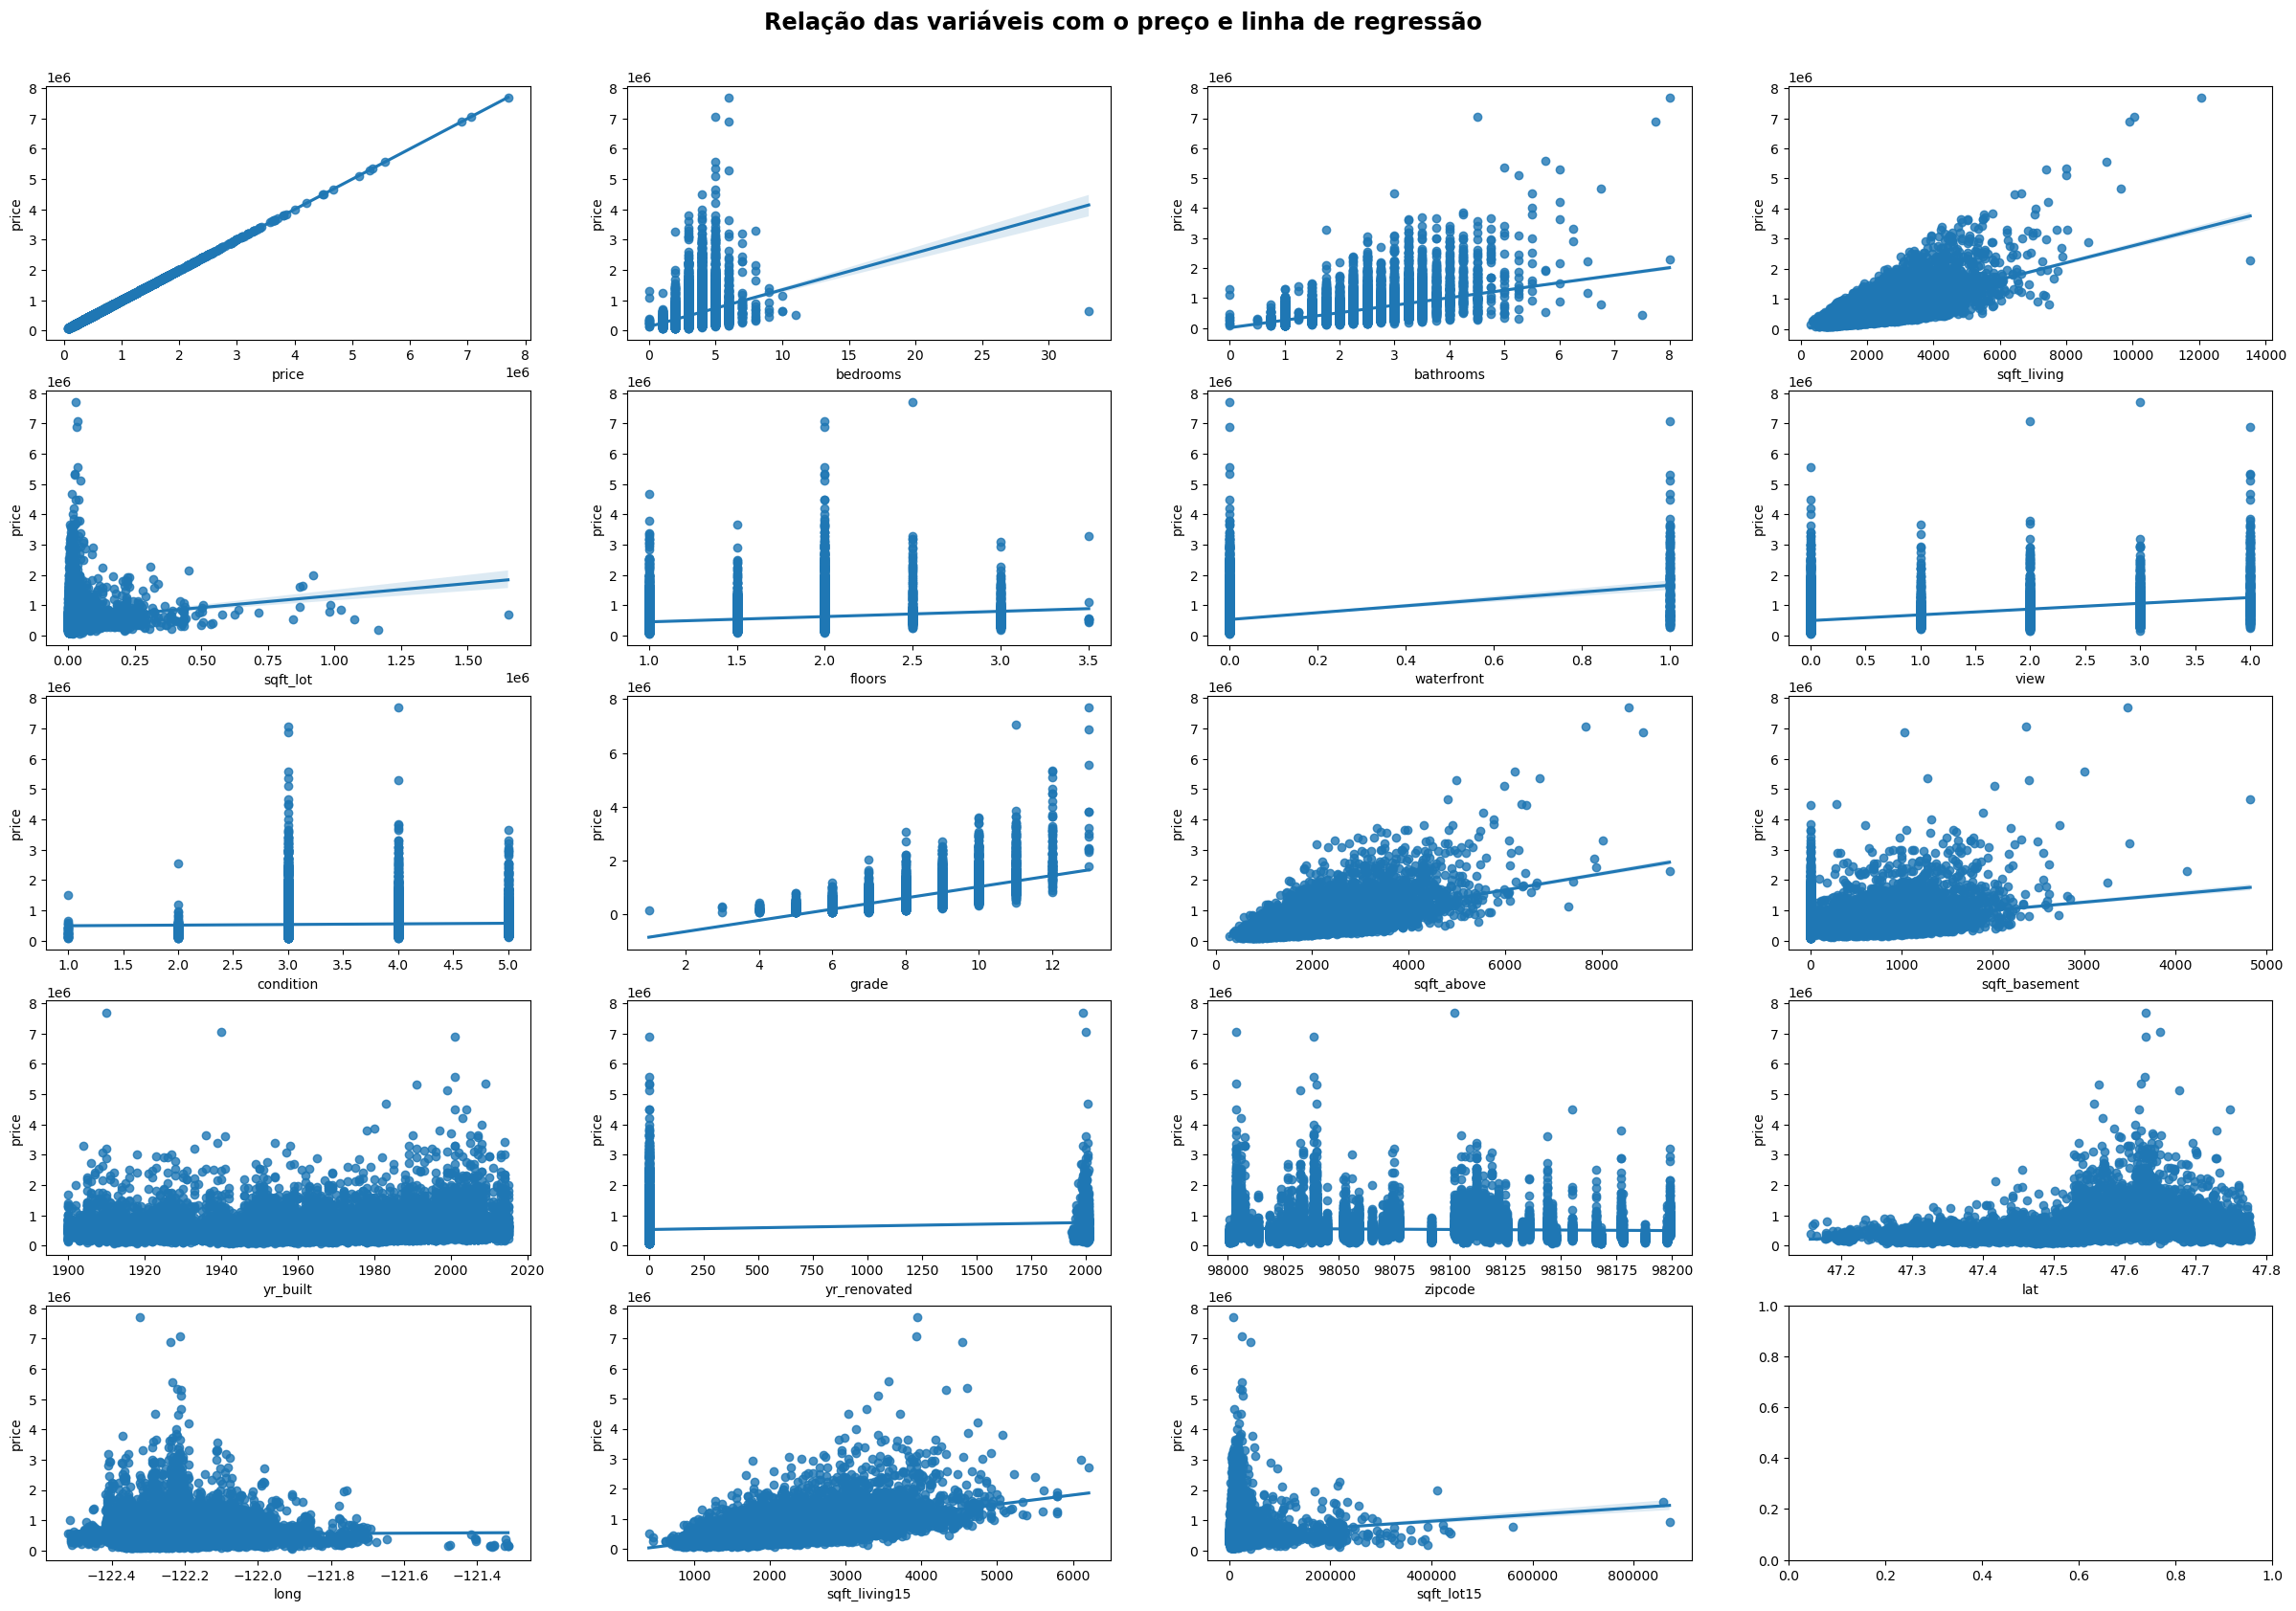

In [22]:
fig, ax = plt.subplots(np.ceil(len(colunas)/4).astype('int8'), 4, figsize=(30,20))
i=0
for col in colunas:
    sns.regplot(
        sales,
        x=sales[col],
        y=sales['price'],
        ax=ax[int(i/4),i%4]
        )
    i+=1

plt.suptitle(
    'Relação das variáveis com o preço e linha de regressão',
    size='xx-large',
    weight='bold',
    y=0.92
    )

<Axes: xlabel='zipcode', ylabel='price'>

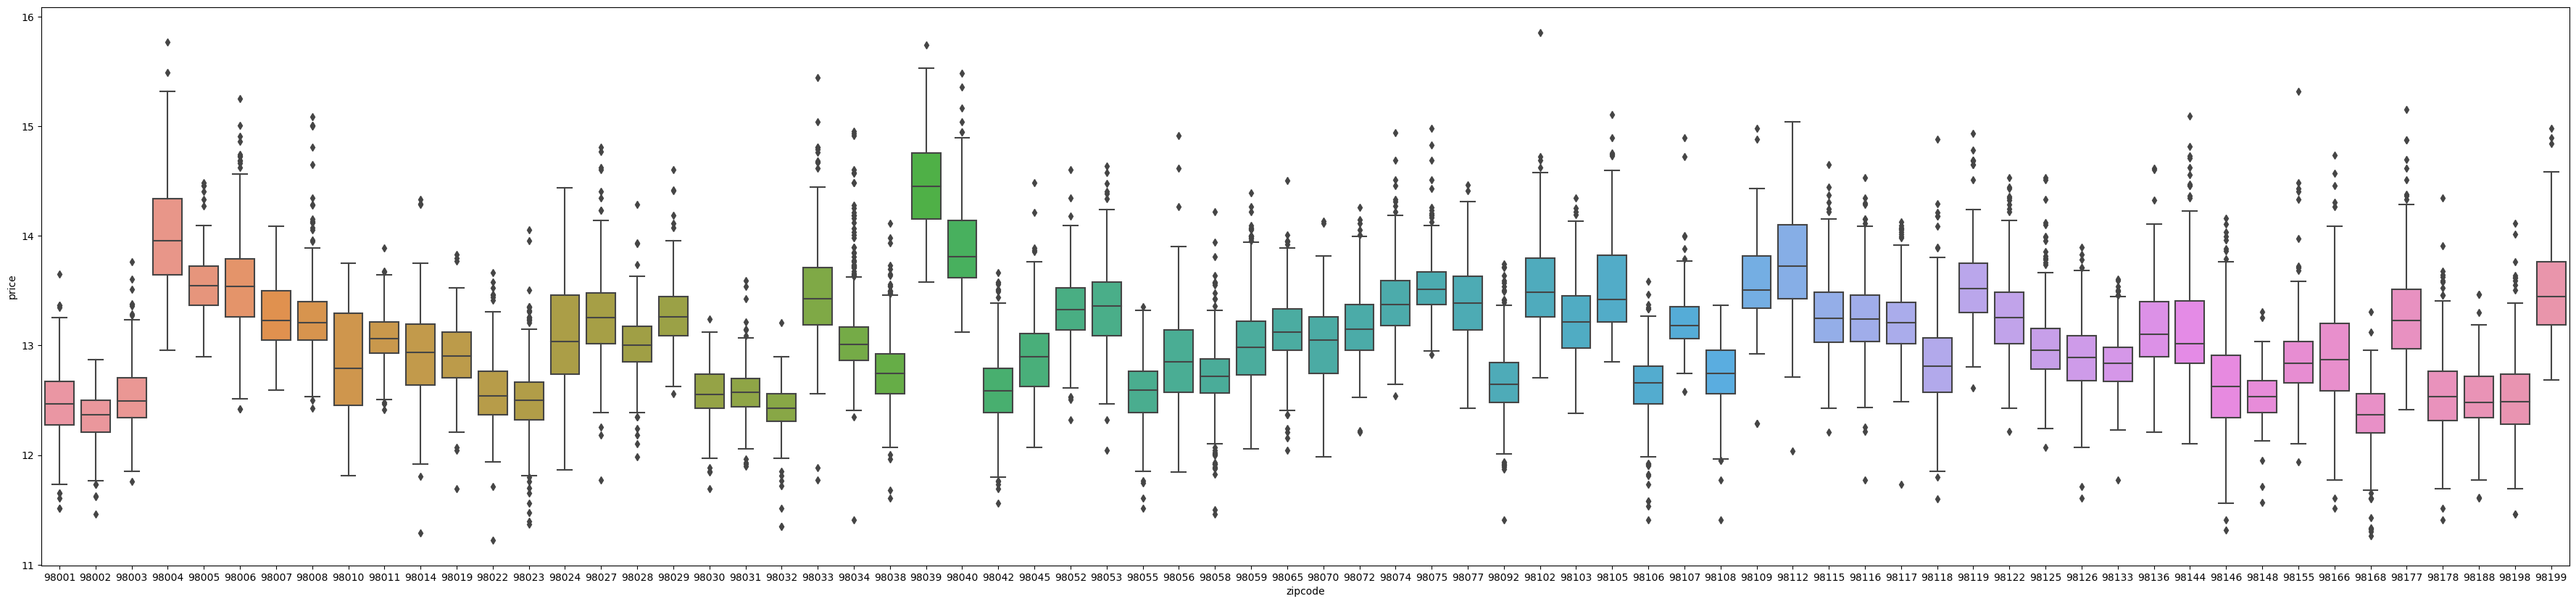

In [23]:
plt.figure(figsize=(45,10))
sns.boxplot(
    sales,
    x=sales['zipcode'],
    y=np.log(sales['price'])
    )

### Atividade 2

Para esta atividade, vocês deverão aplicar as ações de pré-processamento dos dados que julgarem imprescindíveis para o treinamento do algoritmo de aprendizado. Dentre as ações, podemos citar:

1. Limpeza
    * Outliers:
        * Coluna Bedrooms: 33, notavelmente é um outlier, conforme visto no boxplot
        * Verificar colunas:
            * Price
            * Sqft_living comparando com a coluna Sqft_living15
            * Sqft_lot comparando com a coluna Sqft_lot15
    * Remover as colunas:
        * id - feito anteriormente
        * date - feito anteriormente
        * sqft_basement
        * yr_renovated
        * zipcode
        * lat
        * long
1. Transformação
    * Modificação de colunas:
        * Criar coluna:
            * yr_modified para indicar a última modificação na casa com base no ano de construção ou reforma.
        * Modificar coluna:
            * sqft_basement para basement, para indicar se a casa tem porão ou não. O tamanho do porão não vai ser perdido pois a diferença entre sqft_living e sqft_above nos dá a informação da coluna sqft_basement. Redundância.
            * Transformar as colunas lat e long em uma única com a informação de Ponto que pode ser utilizado pelo geopandas.
        * One Hot Encode da coluna zipcode

1. Integração
1. Normalização

## <center>**Pré-Processamento**</center>

In [24]:
sales.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Verificando valores extremos na variável preço, e se estes condizem com a situação do imóvel.

In [25]:
sales.iloc[sales['sqft_living'].nlargest(n=10).index]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12777,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
7252,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
3914,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
9254,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
8092,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454
4411,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
14556,2888000.0,5,6.25,8670,64033,2.0,0,4,3,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021
18302,3300000.0,5,6.25,8020,21738,2.0,0,0,3,11,8020,0,2001,0,98006,47.5675,-122.189,4160,18969
1164,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
1448,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750


In [26]:
sales.iloc[sales['sqft_lot'].nlargest(n=10).index]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1719,700000.0,4,1.00,1300,1651359,1.0,0,3,4,6,1300,0,1920,0,98022,47.2313,-122.023,2560,425581
17319,190000.0,2,1.00,710,1164794,1.0,0,0,2,5,710,0,1915,0,98014,47.6888,-121.909,1680,16730
7647,542500.0,5,3.25,3010,1074218,1.5,0,0,5,8,2010,1000,1931,0,98027,47.4564,-122.004,2450,68825
7769,855000.0,4,3.50,4030,1024068,2.0,0,0,3,10,4030,0,2006,0,98045,47.4619,-121.744,1830,11700
3949,998000.0,4,3.25,3770,982998,2.0,0,0,3,10,3770,0,1992,0,98058,47.4140,-122.087,2290,37141
4441,790000.0,2,3.00,2560,982278,1.0,0,0,3,8,2560,0,2004,0,98014,47.6955,-121.861,1620,40946
6691,1998000.0,2,2.50,3900,920423,2.0,0,0,3,12,3900,0,2009,0,98065,47.5371,-121.756,2720,411962
7077,1650000.0,4,3.25,3920,881654,3.0,0,3,3,11,3920,0,2002,0,98024,47.5385,-121.896,2970,112384
9714,937500.0,4,4.00,5545,871200,2.0,0,0,3,11,3605,1940,2003,0,98014,47.6760,-121.882,3420,871200
20452,1600000.0,4,5.50,6530,871200,2.0,0,2,3,11,6530,0,2008,0,98014,47.6640,-121.878,1280,858132


In [27]:
sales.iloc[sales['price'].nlargest(n=10).index]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7252,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
3914,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
9254,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
4411,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
1448,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
1315,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1164,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
8092,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454
2626,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
8638,4489000.0,4,3.00,6430,27517,2.0,0,0,3,12,6430,0,2001,0,98004,47.6208,-122.219,3720,14592


In [28]:
sales.iloc[sales['price'].nsmallest(n=10).index]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1149,75000.0,1,0.00,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
15293,78000.0,2,1.00,780,16344,1.0,0,0,1,5,780,0,1942,0,98168,47.4739,-122.280,1700,10387
465,80000.0,1,0.75,430,5050,1.0,0,0,2,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500
16198,81000.0,2,1.00,730,9975,1.0,0,0,1,5,730,0,1943,0,98168,47.4808,-122.315,860,9000
8274,82000.0,3,1.00,860,10426,1.0,0,0,3,6,860,0,1954,0,98146,47.4987,-122.341,1140,11250
2141,82500.0,2,1.00,520,22334,1.0,0,0,2,5,520,0,1951,0,98168,47.4799,-122.296,1572,10570
18468,83000.0,2,1.00,900,8580,1.0,0,0,3,5,900,0,1918,0,98168,47.4727,-122.270,2060,6533
3767,84000.0,2,1.00,700,20130,1.0,0,0,3,6,700,0,1949,0,98168,47.4752,-122.271,1490,18630
10253,85000.0,2,1.00,830,9000,1.0,0,0,3,6,830,0,1939,0,98032,47.3813,-122.243,1160,7680
16714,85000.0,2,1.00,910,9753,1.0,0,0,3,5,910,0,1947,0,98032,47.3897,-122.236,1160,7405


In [29]:
sales.groupby('bedrooms')['bedrooms'].count()

bedrooms
0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [30]:
sales[sales['bedrooms']==33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


### Definindo qual a melhor forma de substituir o valor discrepante:
* Pelo tamanho da casa
* Pelo preço de venda da casa

In [31]:
bedroom = sales['bedrooms'].unique()
bedroom.sort()

In [32]:
for bed in bedroom:
    size = sales[sales['bedrooms']==bed]['sqft_living'].mean()
    print(f"Number of bedrooms: {bed} | House Size: {size:.2f} ft²")

Number of bedrooms: 0 | House Size: 1707.85 ft²
Number of bedrooms: 1 | House Size: 884.61 ft²
Number of bedrooms: 2 | House Size: 1239.75 ft²
Number of bedrooms: 3 | House Size: 1805.84 ft²
Number of bedrooms: 4 | House Size: 2554.65 ft²
Number of bedrooms: 5 | House Size: 3047.55 ft²
Number of bedrooms: 6 | House Size: 3284.34 ft²
Number of bedrooms: 7 | House Size: 3974.21 ft²
Number of bedrooms: 8 | House Size: 3800.00 ft²
Number of bedrooms: 9 | House Size: 3775.00 ft²
Number of bedrooms: 10 | House Size: 3706.67 ft²
Number of bedrooms: 11 | House Size: 3000.00 ft²
Number of bedrooms: 33 | House Size: 1620.00 ft²


In [33]:
for bed in bedroom:
    price = sales[sales['bedrooms']==bed]['price'].mean()
    print(f"Number of bedrooms: {bed} | House Price: ${price:.2f}")

Number of bedrooms: 0 | House Price: $409503.85
Number of bedrooms: 1 | House Price: $317642.88
Number of bedrooms: 2 | House Price: $401372.68
Number of bedrooms: 3 | House Price: $466232.08
Number of bedrooms: 4 | House Price: $635419.50
Number of bedrooms: 5 | House Price: $786599.83
Number of bedrooms: 6 | House Price: $825520.64
Number of bedrooms: 7 | House Price: $951184.66
Number of bedrooms: 8 | House Price: $1105076.92
Number of bedrooms: 9 | House Price: $893999.83
Number of bedrooms: 10 | House Price: $819333.33
Number of bedrooms: 11 | House Price: $520000.00
Number of bedrooms: 33 | House Price: $640000.00


As casas com 0 e 3 quartos tem média de tamanho próximos. Já pelo preço está mais bem definido o número de quartos.

In [34]:
sales[sales['price']==640000].count()

price            52
bedrooms         52
bathrooms        52
sqft_living      52
sqft_lot         52
floors           52
waterfront       52
view             52
condition        52
grade            52
sqft_above       52
sqft_basement    52
yr_built         52
yr_renovated     52
zipcode          52
lat              52
long             52
sqft_living15    52
sqft_lot15       52
dtype: int64

In [35]:
sales.replace(
        {'bedrooms' : 33},
        int(sales[sales['price']==640000]['bedrooms'].mean()),
        inplace=True
        )

In [36]:
sales.iloc[15870]

price            640000.0000
bedrooms              4.0000
bathrooms             1.7500
sqft_living        1620.0000
sqft_lot           6000.0000
floors                1.0000
waterfront            0.0000
view                  0.0000
condition             5.0000
grade                 7.0000
sqft_above         1040.0000
sqft_basement       580.0000
yr_built           1947.0000
yr_renovated          0.0000
zipcode           98103.0000
lat                  47.6878
long               -122.3310
sqft_living15      1330.0000
sqft_lot15         4700.0000
Name: 15870, dtype: float64

### *Modificando o dataset:*

In [245]:
sales_mod = sales.copy()

Incluindo uma coluna com os anos desde a última modificação na casa.

In [246]:
sales_mod['yr_modified'] = np.where(
                                sales_mod['yr_renovated']==0,
                                sales['yr_built'],
                                sales['yr_renovated']
                                )

In [247]:
sales_mod['yr_modified'] = 2015-sales_mod['yr_modified']

Criando uma coluna indicando se a casa foi reformada ou não.

In [248]:
sales_mod['renovated'] = np.where(sales_mod['yr_renovated']!=0, 1, 0)

In [249]:
sales_mod.drop(
            ['yr_renovated'],
            axis=1,
            inplace=True
            )

Alterando a variável do porão:

In [250]:
sales_mod['basement'] = np.where(sales_mod['sqft_basement']!=0, 1, 0)

In [251]:
sales_mod.drop(
            ['sqft_basement'],
            axis=1,
            inplace=True
            )

Modificando as variáveis de coordenadas para o formato Ponto.

In [252]:
from shapely.geometry import Point

In [253]:
sales_mod['coordinates'] = [
                            Point(xy)
                            for xy in zip(sales_mod.long, sales_mod.lat)
                            ]

In [254]:
sales_mod.drop(
            ['lat', 'long'],
            axis=1,
            inplace=True
            )

One hot encoding da coluna zipcode

In [256]:
ohe = OneHotEncoder()
data = pd.DataFrame(sales_mod['zipcode'])
data = ohe.fit_transform(data)
zipcode = pd.DataFrame(
                data.toarray(),
                columns=ohe.get_feature_names_out(),
                dtype=int
                )

In [257]:
sales_mod['bedrooms']=sales_mod['bedrooms'].astype('int8')
sales_mod['bathrooms']=sales_mod['bathrooms'].astype('float16')
sales_mod['basement']=sales_mod['basement'].astype('bool')
sales_mod['floors']=sales_mod['floors'].astype('float16')
sales_mod['sqft_living']=sales_mod['sqft_living'].astype('int32')
sales_mod['sqft_lot']=sales_mod['sqft_lot'].astype('int32')
sales_mod['sqft_above']=sales_mod['sqft_above'].astype('int32')
sales_mod['sqft_living15']=sales_mod['sqft_living15'].astype('int32')
sales_mod['sqft_lot15']=sales_mod['sqft_lot15'].astype('int32')
sales_mod['waterfront']=sales_mod['waterfront'].astype('bool')
sales_mod['view']=sales_mod['view'].astype('int8')
sales_mod['condition']=sales_mod['condition'].astype('int8')
sales_mod['grade']=sales_mod['grade'].astype('int8')
sales_mod['yr_built']=sales_mod['yr_built'].astype('int16')
sales_mod['yr_modified']=sales_mod['yr_modified'].astype('int16')
sales_mod['renovated']=sales_mod['renovated'].astype('bool')
sales_mod['zipcode']=sales_mod['zipcode'].astype('int32')

In [258]:
sales_mod=sales_mod[
                    ['price',
                     'bedrooms',
                     'bathrooms',
                     'basement',
                     'floors',
                     'sqft_living',
                     'sqft_above',
                     'sqft_lot',
                     'sqft_living15',
                     'sqft_lot15',
                     'waterfront',
                     'view',
                     'condition',
                     'grade',
                     'yr_built',
                     'yr_modified',
                     'renovated',
                     'zipcode',
                     'coordinates']
                     ]

In [259]:
sales_mod=sales_mod.join(zipcode)

## <center>Salvando o Dataframe para arquivo</center>

Exportando o dataframe para csv:

In [260]:
sales_mod.to_csv('processed/kc_house_data.csv')

Exportando o dataframe para parquet:

In [261]:
sales_mod.drop(
            ['zipcode', 'coordinates'],
            axis=1,
            inplace=True
            )

In [262]:
sales_mod.to_parquet('processed/kc_house_data.parquet')

## <center>Organizando o dataset para treinamento</center>

In [263]:
df = pd.read_parquet('processed/kc_house_data.parquet')

In [265]:
X = df.copy()

Transformação da variável objetivo

In [267]:
pt = PowerTransformer(method='box-cox', standardize=False)
#pt = PowerTransformer(standardize=False)
pt.fit(X['price'].values.reshape(-1,1))

PowerTransformer(method='box-cox', standardize=False)

In [268]:
#y = np.log10(X['price'])
#y = X['price']
y = pt.transform(X['price'].values.reshape(-1,1))


Removendo a variável objetivo das variáveis independentes.

In [269]:
X.drop(
    ['price'],
    axis=1,
    inplace=True
    )

## <center>Modelos</center>

In [270]:
def create_model (data, target, algorithm, splitsize, scaler=None):
    if scaler != None:
        X = scaler.fit_transform(data)
    else:
        X = data
        
    y = target
    X_train, X_test, y_train, y_test = train_test_split(
                                                    X, #data
                                                    y, #targets
                                                    test_size=splitsize,
                                                    random_state=1
                                                    )
    model = algorithm
    model.fit(X_train, y_train)

    return (model, X_train, X_test, y_train, y_test)

In [271]:
#scaler = RobustScaler(with_centering=False, with_scaling=True)
#scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = MaxAbsScaler()

In [272]:
regressor = [
            LinearRegression(),
            DecisionTreeRegressor(),
            RandomForestRegressor(
                            n_estimators=200,
                            random_state=10,
                            max_samples=0.9,
                            max_features=0.8,
                            max_depth=30
                            ),
            xgb.XGBRegressor(
                            objective='reg:squarederror',
                            #n_estimators=10000,
                            #max_depth=3,
                            #colsample_bytree=0.5,
                            #learning_rate=0.001,
                            random_state=0,
                            #subsample=0.5,
                            n_jobs=-1,
                            #eval_metric='mae',
                            verbosity=0
                            ),
            CatBoostRegressor(
                            loss_function='RMSE',
                            iterations=10000,
                            depth=3,
                            colsample_bylevel=.4,
                            eval_metric='MAE',
                            subsample=.5,
                            random_state=0,
                            verbose=0,
                            eta=.1
                            )
            ]

In [273]:
#model, X_train, X_test, y_train, y_test = create_model(X, y, regressor[3], 0.2, scaler)
model, X_train, X_test, y_train, y_test = create_model(X, y, regressor[3], 0.2)

In [274]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'Score (r2 metric from the model): {model.score(X_test, y_test)}')
print(f'R2 (Test): {r2_score(y_test, y_pred)}')
print(f'R2 (Training): {r2_score(y_true=y_train, y_pred=model.predict(X_train))}')

MAE: 0.006
RMSE: 0.009
Score (r2 metric from the model): 0.8704210297568096
R2 (Test): 0.8704210297568096
R2 (Training): 0.9255470595834567


In [ ]:
#y_test = pt.inverse_transform(y_test)
#y_pred = pt.inverse_transform(y_pred.reshape(-1,1))


print('Real \t \t Predicted')
for item in range(len(y_pred)):
    print("${0:,.2f}\t${1:,.2f}".format(10**y_test[item,0], 10**y_pred[item]))

In [270]:
#cv = StratifiedKFold(n_splits=10) #faz a coluna de target se tornar rótulos
cv = KFold(n_splits=10)
n_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(f'R squared: {(mean(n_scores), std(n_scores))}')

R squared: (0.8951027949411277, 0.004950703624706784)


In [ ]:
parameters = {
            'depth' : [3, 6, 8, 10],
            'learning_rate' : [0.001, 0.01, 0.05, 0.1],
            'iterations' : [30, 50, 100, 1000]
            }

grid = GridSearchCV(
                    estimator=model,
                    param_grid=parameters,
                    cv=2,
                    n_jobs=-1
                    )

grid.fit(X_train, y_train)

In [ ]:
# Results from Grid Search
print("Results from Grid Search")

print("\n The best estimator (model) across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)